In [29]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, auc

In [2]:
# !python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

## Prep work

In [3]:
df = pd.read_csv('AER_credit_card_data.csv')

In [4]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df['card'] = df['card'].apply(lambda x: 1 if x == 'yes' else 0)

In [6]:
df['card'].value_counts()

1    1023
0     296
Name: card, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [10]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [11]:
y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

In [12]:
del df_train['card']
del df_val['card']
del df_test['card']

In [13]:
df.dtypes

card             int64
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [14]:
numerical_cols = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']
categorical_cols = ['owner', 'selfemp']
target_col = ['card']

## Question 1

In [15]:
store = []
for i in numerical_cols:
    model = LogisticRegression()
    model.fit(df_train[[i]], y_train)
    y_pred = model.predict_proba(df_train[[i]])[:, 1]
    store.append([i,roc_auc_score(y_train, y_pred).round(4)])

In [16]:
pd.DataFrame(store, columns=['feature', 'auc']).sort_values(by='auc', ascending=False)

,feature,auc
3,share,0.9921
4,expenditure,0.9919
0,reports,0.7265
2,income,0.5918
8,active,0.5615
5,dependents,0.5548
7,majorcards,0.5491
6,months,0.5397
1,age,0.5072


We can see that out of the 4 suggested, share has the largest AUC.

## Question 2

In [17]:
use_cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [18]:
def train_logistic_regression(df_train, y_train, C=1.0):
    dicts = df_train[use_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [19]:
def predict(df, dv, model):
    dicts = df[use_cols].to_dict(orient='records')

    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [20]:
dv, model = train_logistic_regression(df_train, y_train)

In [21]:
y_pred = predict(df_val, dv, model)

In [22]:
round(roc_auc_score(y_val, y_pred), 3)

0.99

## Question 3

In [23]:
thresholds = np.arange(0.0, 1.0, 0.01)

In [24]:
scores = []
for t in thresholds:
    real_positive = (y_val == 1)
    real_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & real_positive).sum()
    tn = (predict_negative & real_negative).sum()

    fp = (predict_positive & real_negative).sum()
    fn = (predict_negative & real_positive).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append([t, precision, recall])

In [27]:
scores_df = pd.DataFrame(scores, columns=['threshold', 'precision','recall'])

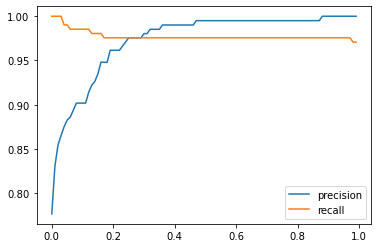

In [30]:
plt.plot(scores_df.threshold, scores_df.precision, label='precision')
plt.plot(scores_df.threshold, scores_df.recall, label='recall')
plt.legend()
plt.show()

The curves intersect at around 0.2-0.3

## Question 4

In [31]:
def f1(precision, recall):
    return 2 * ((precision * recall) / (precision + recall))

In [39]:
scores_df['f1_score'] = f1(scores_df.precision, scores_df.recall)

In [47]:
scores_df.sort_values(by='f1_score', ascending=False)

,threshold,precision,recall,f1_score
89,0.89,1.000000,0.975610,0.987654
93,0.93,1.000000,0.975610,0.987654
88,0.88,1.000000,0.975610,0.987654
91,0.91,1.000000,0.975610,0.987654
92,0.92,1.000000,0.975610,0.987654
...,...,...,...,...
4,0.04,0.875000,0.990244,0.929062
3,0.03,0.864979,1.000000,0.927602
2,0.02,0.854167,1.000000,0.921348
1,0.01,0.829960,1.000000,0.907080


In [58]:
maximal_f1_score = scores_df.nlargest(n=15, columns='f1_score')[['threshold', 'f1_score']]

In [59]:
maximal_f1_score

,threshold,f1_score
88,0.88,0.987654
90,0.90,0.987654
91,0.91,0.987654
92,0.92,0.987654
93,0.93,0.987654
94,0.94,0.987654
95,0.95,0.987654
96,0.96,0.987654
97,0.97,0.987654
89,0.89,0.987654


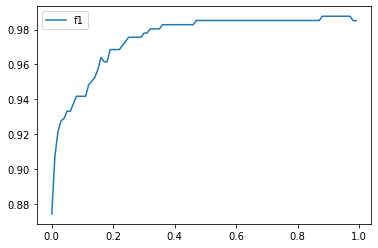

In [42]:
plt.plot(scores_df.threshold, scores_df.f1_score, label='f1')
plt.legend()
plt.show()

Max F1 is achieved at around 0.4

## Question 5

In [61]:
kFold = KFold(n_splits=5, shuffle=True, random_state=1)

In [62]:
scores = []

In [63]:
for train_idx, val_idx in kFold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train_logistic_regression(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [67]:
print(round(np.std(scores),3))

0.002


The closest answer is 0.003.

## Question 6

In [75]:
c_values = [0.01, 0.1, 1, 10]
fold_data = []

In [76]:
for C in c_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train_logistic_regression(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    fold_data.append([C, np.mean(scores).round(3), np.std(scores).round(3)])

In [77]:
fold_data

[[0.01, 0.992, 0.004],
 [0.1, 0.994, 0.002],
 [1, 0.996, 0.002],
 [10, 0.996, 0.002]]

C=1 leads to the best mean score